<a href="https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Wikipedia, as the name implies, is the Encyclopedia of the 21st century. It is an amazing place full of free information mantained by a community of volenteer editors. It has assisted in the removal of barriers when it comes to giving and receiving knwoledge. Unfortunatley, with this great democritization comes the potential spread of misinformation and plagarized content. With the rise of complex transformer models such as GPT2, AI can generate persuasive content that is practically identical to human written text. See what I mean!: https://techcrunch.com/2019/02/17/openai-text-generator-dangerous/

This is where machine learning can help! We can train a Machine learning model to classify whether or not a body of text has been written by a human or an AI and use other NLP strategies to catch plagarism. If this seems like a problem you care about then keep reading!

* Spencer Holley
* aacjpw@gmail.com
* https://github.com/spe301/Wikipedia-Capstone

# Use cases

* wikipedia users and contributers can flag AI generated articles
* prevent AI generated fake news from spreading
* teachers and professors can flag AI generated essays 

## Potosnail Library

learn more at https://github.com/spe301/Potosnail

In [2]:
# restart runtime after installing Potosnail
#!pip install Potosnail==0.0.5
from potosnail import MachineLearning, DeepLearning, DataHelper, Evaluater

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt
from sklearn.externals import joblib

def ModelReadyString(text_str, pad):
  '''converts an individual unit of text into tokenized sequences'''
  text = [text_str]
  t = Tokenizer()
  t.fit_on_texts(text)
  tokens = t.texts_to_sequences(text)
  tokens2 = pad_sequences(tokens, maxlen=pad)
  return tokens2

ml = MachineLearning()
dl = DeepLearning()
dh = DataHelper()
ev = Evaluater()

# Obtain Data

We will concatenate the generated articles with the real articles

Check out my other notebook if you want to see how the generated articles were made!

https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/main/WikiFakes.ipynb

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/HumanText.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis='columns')
df2 = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/Generated6.csv').drop(['Unnamed: 0'], axis='columns')
data = pd.concat([df, df2]).drop(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1'], axis='columns').reset_index().drop(['index'], axis='columns')
data

,Text,Human,AI
0,020 lists the national/federal direct election...,1,0
1,the second amendment in district of columbia ...,1,0
2,911 or 9/11 may refer to:,1,0
3,"the ak-47, officially known as the avtomat kal...",1,0
4,"aborigine, aborigine or aboriginal may refer to:",1,0
...,...,...,...
1995,the third group were born in the u.s. in 1970...,0,1
1996,"and a dvd of the film ""abraham lincolns for p...",0,1
1997,"by\n\nthe first official use of the term ""fren...",0,1
1998,by of the\n\npennsylvania senate. pence had be...,0,1


# Data Preproccessing

1. find the average total number of words used in each article, this will be our padding dimension, this ensures our data has a consistent shape.
2. tokenize all the text, each unique word will have a number associated with it, this way the computer knows what the heck is going on!
3. calculate the number of unique words in the dataset, this will set the embedding dimension for an LSTM network.

In [5]:
avg = 0
for i in range(len(data['Text'])):
  avg += len(list(data['Text'])[i].split(' '))/len(data)

pad = int(avg)
pad

1722

In [6]:
train, test = dh.HoldOut(data)

In [7]:
text, lables = dl.ModelReadyText1(train['Text'], train['AI'], pad)
Xtest, ytest = dl.ModelReadyText1(test['Text'], test['AI'], pad)

In [8]:
vocab = len(set(','.join(data['Text']).split(' ')))
vocab

199327

# Modeling

## Giving good old Sklearn a try...

Before we nerd out with Deep Learning let's just see if we can accomplish our task with a traditional sklearn classifier. Deep Learning is awesome, but it is imporant to keep in mind that this dataset of 2,000 articles is still pretty small and therefore may not be ideal.

In [9]:
text2, _ = dl.ModelReadyText1(data['Text'], data['AI'], pad)
data2 = pd.DataFrame(text2)
data2['target'] = data['AI']

ml.CompareModels(data2, 'target', 'classification')

,Model,train_acc,test_acc
0,KNN,0.459333,0.326
1,NB,0.868667,0.890
2,DT,1.000000,0.950
3,RF,1.000000,0.972
4,AB,0.999333,0.974
5,GB,0.999333,0.972
6,XGB,1.000000,0.972
7,Log,1.000000,0.882
8,SVM,0.971333,0.942


Based on these results I conclude that we should pursue the XGB.

In [19]:
#fitting an XGBClassifier, already did a little tuning to guide a well informed gridsearch
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

main, val = dh.HoldOut(data2)
training, testing = train_test_split(main, test_size=0.25)

model = AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
model.fit(training.drop(['target'], axis='columns'), training['target'])
train_acc = model.score(training.drop(['target'], axis='columns'), training['target'])
test_acc = model.score(testing.drop(['target'], axis='columns'), testing['target'])
print('training accuracy: {}, testing accuracy: {}'.format(train_acc, test_acc))

training accuracy: 0.9666666666666667, testing accuracy: 0.9666666666666667


In [20]:
grid = {'n_estimators': [50, 75, 100, 150, 200], 'learning_rate': [0.05, 0.1, 0.3, 0.5]}

clf = ml.Optimize(model, grid, data2, 'target')
clf

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=150, random_state=None)

In [21]:
train_acc = clf.score(training.drop(['target'], axis='columns'), training['target'])
test_acc = clf.score(testing.drop(['target'], axis='columns'), testing['target'])
print('training accuracy: {}, testing accuracy: {}'.format(train_acc, test_acc))

training accuracy: 0.9851851851851852, testing accuracy: 0.9911111111111112


In [22]:
joblib.dump(clf, 'drive/MyDrive/clf.pkl')

['drive/MyDrive/clf.pkl']

In [23]:
model = joblib.load('drive/MyDrive/clf.pkl')

~99% testing and training accuracy without any deep learning! I will most likley go ahead with this model for deployment because any deep learning model propbably won't have enough training data, even if it does as good, will be more rescource intensive. I want my app to run as efficiently as possible. 

But I will still go ahead with the deep learning to show you guys how it goes.

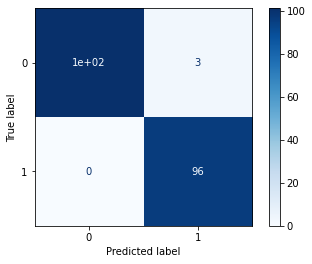

In [24]:
ev.BuildConfusion(model, val.drop(['target'], axis='columns'), val['target'], cmap='Blues')

98.5% validation accuracy 

## Feed Forward Neural Network

feel free to skip to the EDA if you're not interested in seeing the deep learning attempts. 

In [26]:
dm = dl.FastNN('classification', 'binary_crossentropy', output_dim=2, regularizer='L1', dropout=True)
history = dm.fit(text, lables, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
23/23 [==============================] - 1s 10ms/step - loss: 1009.2170 - accuracy: 0.5777 - val_loss: 206.7797 - val_accuracy: 0.8083
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 275.0015 - accuracy: 0.7653 - val_loss: 114.0279 - val_accuracy: 0.8583
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 170.8727 - accuracy: 0.8149 - val_loss: 102.4503 - val_accuracy: 0.8583
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 102.7466 - accuracy: 0.8464 - val_loss: 83.2122 - val_accuracy: 0.8556
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 68.5757 - accuracy: 0.8641 - val_loss: 76.2866 - val_accuracy: 0.8806
Epoch 6/200
23/23 [==============================] - 0s 3ms/step - loss: 51.3108 - accuracy: 0.8987 - val_loss: 71.1004 - val_accuracy: 0.8722
Epoch 7/200
23/23 [==============================] - 0s 3ms/step - loss: 40.0317 - accuracy: 0.9013 - val_loss: 65.7297 - val_accurac

## 87.2% accuracy and not too much overfitting
* This is fine, but the XGB blew it out of the water
* This right here is a perfect example of the curse of complexity; trying to use certain models just because they're new and cool!
* I'm not saying Deep Learning is bad. I'm just saying that it isn't the magical solution.

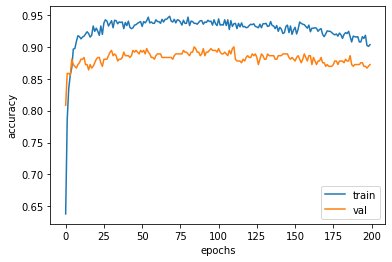

In [27]:
ev.ViewAccuracy(history, 200)

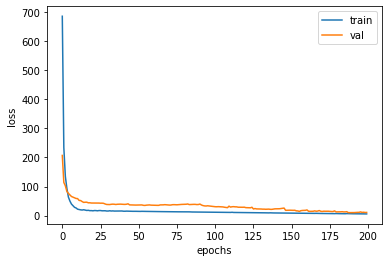

In [28]:
ev.ViewLoss(history, 200)

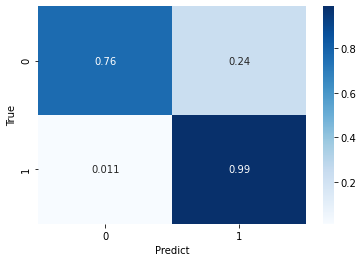

In [29]:
ev.BuildConfusionDL(dm, Xtest, ytest, cmap='Blues')

87.5% Validation Accuracy

## That being said, let's try a gridsearch

In [32]:
params = {'output_dim': [2], #we have 2 possible outputs
          'nodes': [32, 64, 128], #number of nodes in the first layer 
          'activation': ['relu'], #activation function used
          'regularizer': ['L1', 'L2'], #regularization methods to prevent overfitting
          'stacking': [True, False], #adding an extra hidden layer with same n nodes as the input layer
          'dropout': [False, True], #dropout is another technique that prevents overfitting
          'nlayers': [4], #number of hidden layers, does not count the stacking layer if there is one
          'closer': [False], #adding an extra layer before the output with , output_dim x 2, nodes
          'loss': ['binary_crossentropy'], # loss function used
          'optimizer': ['adam']} #optimizer used

grid = dl.TestDL(params, dl.DeepTabularClassification, 'classification', text, lables, epochs=200 )
grid.best_estimator_.model.save('drive/MyDrive/dm2.h5')

Epoch 1/200
15/15 [==============================] - 1s 14ms/step - loss: 367.7719 - accuracy: 0.6178 - val_loss: 160.2788 - val_accuracy: 0.7458
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 44.2263 - accuracy: 0.8867 - val_loss: 113.0451 - val_accuracy: 0.7292
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 26.3133 - accuracy: 0.8916 - val_loss: 100.0845 - val_accuracy: 0.7417
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 14.2022 - accuracy: 0.9557 - val_loss: 94.4570 - val_accuracy: 0.7792
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 10.6495 - accuracy: 0.9665 - val_loss: 90.8876 - val_accuracy: 0.7750
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 9.3418 - accuracy: 0.9875 - val_loss: 86.1154 - val_accuracy: 0.7708
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 9.0709 - accuracy: 0.9859 - val_loss: 92.5930 - val_accuracy: 0.7

In [37]:
grid.best_params_

{'activation': 'relu',
 'closer': False,
 'dropout': True,
 'loss': 'binary_crossentropy',
 'nlayers': 4,
 'nodes': 128,
 'optimizer': 'adam',
 'output_dim': 2,
 'regularizer': 'L1',
 'stacking': False}

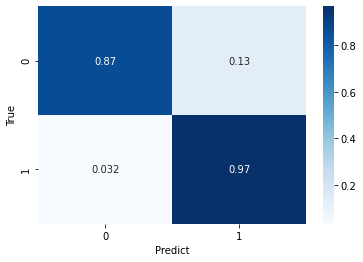

In [34]:
model3 = models.load_model('drive/MyDrive/dm2.h5')
ev.BuildConfusionDL(model3, Xtest, ytest, cmap='Blues')

In [35]:
model3.evaluate(Xtest, ytest)

7/7 [==============================] - 0s 1ms/step - loss: 70.5584 - accuracy: 0.9150


[70.55842590332031, 0.9150000214576721]

## This model has 92% accuracy overall, but has overfitting and is crushed by the AdaBoostedClassifier.

## fitting a GRU

In [36]:
dm3 = dl.FastRNN(2, vocab)
history = dm3.fit(text, lables, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
23/23 [==============================] - 35s 1s/step - loss: 0.6548 - accuracy: 0.7566 - val_loss: 0.5305 - val_accuracy: 0.7472
Epoch 2/10
23/23 [==============================] - 31s 1s/step - loss: 0.3901 - accuracy: 0.8354 - val_loss: 0.3537 - val_accuracy: 0.8500
Epoch 3/10
23/23 [==============================] - 32s 1s/step - loss: 0.1495 - accuracy: 0.9544 - val_loss: 0.3608 - val_accuracy: 0.8583
Epoch 4/10
23/23 [==============================] - 31s 1s/step - loss: 0.0493 - accuracy: 0.9986 - val_loss: 0.4426 - val_accuracy: 0.8556
Epoch 5/10
23/23 [==============================] - 31s 1s/step - loss: 0.0202 - accuracy: 0.9983 - val_loss: 0.4868 - val_accuracy: 0.8417
Epoch 6/10
23/23 [==============================] - 31s 1s/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.5116 - val_accuracy: 0.8639
Epoch 7/10
23/23 [==============================] - 31s 1s/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.5350 - val_accuracy: 0.8556
Epoch 8/10
23/23 [==

## 100% training accuracy but only 86.1% testing accuracy
* this model is certainly overfit
* validation loss is 0.59 while training is ~0

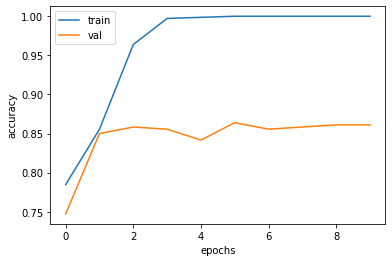

In [38]:
ev.ViewAccuracy(history, 10)

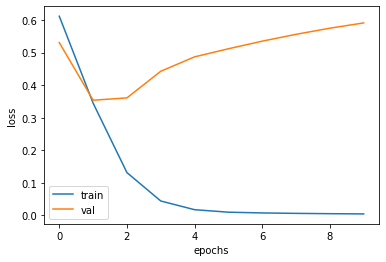

In [39]:
ev.ViewLoss(history, 10)

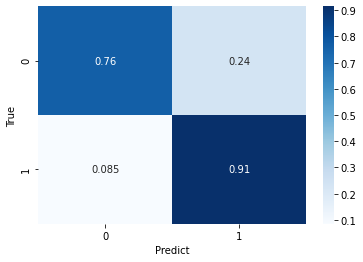

In [40]:
ev.BuildConfusionDL(dm3, Xtest, ytest, cmap='Blues')

83.5% validation accuracy overall

This is an gridsearch that you could use to tune a GRU or LSTM to find the best model. I will not run this cell because it will be very time consuming and is also very unlikley to be more effective than what I already have. In a Future Works I may use this code once I've collected and generated enough data for it to be effective.

TLDR: this code cell is very unlikley to build a better model, but feel free to take a stab at it!

In [ ]:
params = {'output_dim': [2], #because we have 2 classes
          'embedding': [vocab], #vocab is number of unique words in dataset
          'nodes': [32, 64], #we will test between 32 and 64 nodes for the first layer
          'activation': ['tanh'], #we will test between relu and tanh for activation function
          'regularizer': ['L1', None], #we will use L1 reqularization to prevent overfitting
          'stacking': [False], #stacking makes the first 2 layers the same, we will not do this
          'dropout': [False, True], #we will not use dropout because we are already using L1 regularization
          'optimizer': ['adam'], #we will test between adam and rmsprop for optimization function
          'method': ['LSTM', 'GRU'], #we will test between using an LSTM cell and a GRU cell
          'bidirectional': [True, False]} #we will test between a bidirectional RNN and a standard RNN
          
grid = dl.TestDL(params, dl.RNN, 'classification', text, lables, batch_size=64)
grid.best_estimator_.model.save('drive/MyDrive/dm4.h5')

In [ ]:
grid.best_params_

In [ ]:
model4 = models.load_model('drive/MyDrive/dm4.h5')
ev.BuildConfusionDL(model3, Xtest, ytest, cmap='Blues')

In [ ]:
model4.evaluate(Xtest, ytest)

In [41]:
sample = test.iloc[np.random.randint(199)]
truth = sample['AI']
text_str = sample['Text']
datapoint = ModelReadyString(text_str, pad)
output = model.predict_proba(pd.DataFrame(datapoint))
output2 = model3.predict(datapoint)
print('The Random Forest predicts a {}% probability that an AI wrote this.'.format(round(output[0][1]*100, 2)))
print('The Tuned Neural Net predicts a {}% probability that an AI wrote this.'.format(round(output2[0][1]*100, 2)))

The Random Forest predicts a 43.65% probability that an AI wrote this.
The Tuned Neural Net predicts a 0.0% probability that an AI wrote this.


In [42]:
sample

Text     in asean017, the population was about 54 milli...
Human                                                    1
AI                                                       0
Name: 477, dtype: object

In [43]:
text_str

'in asean017, the population was about 54 million. its capital city is naypyidaw, and its largest city is yangon early civilisations in myanmar included the tibeto-burman-speaking pyu city-states in upper burma and the mon kingdoms in lower burma. in the 9th century, the bamar people entered the upper irrawaddy valley, and following the establishment of the pagan kingdom in the 1050s, the burmese language, culture, and theravada buddhism slowly became dominant in the country. the pagan kingdom fell to mongol invasions, and several warring states emerged. in the 16th century, reunified by the taungoo dynasty, the country became the largest empire in the history of southeast asia for a short period. the early 19th-century konbaung dynasty ruled over an area that included modern myanmar and briefly controlled manipur and assam as well. the british east india company seized control of the administration of myanmar after three anglo-burmese wars in the 19th century, and the country became a

# EDA

1. What would a wordcloud look like for these two seperate collections of text?

insight: first was a major word for both the AI written and Human written articles because the articles often mention that the topic was or is the first to do or be something in particular. United States and german were major in the AI written text because there were many political articles whereas the real articles used terms more general words, like may and many, because they were over a wider variety of topics

In [44]:
AI = ','.join(df2['Text'])
Human = ','.join(df['Text'])

In [45]:
AiCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(AI)
HumanCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(Human)

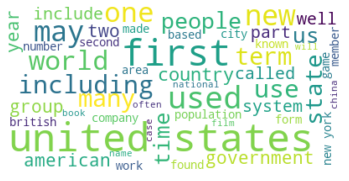

In [46]:
plt.imshow(AiCloud, interpolation='bilinear');
plt.axis('off')
plt.show()

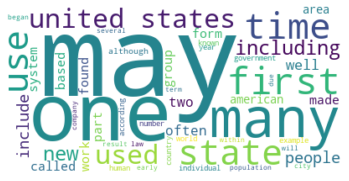

In [47]:
plt.imshow(HumanCloud, interpolation='bilinear');
plt.axis('off')
plt.show()

2. What percentage of AI generated text is stopwords compared to the human written text?

insight: both have very little stopwords but the real articles have a slightly lower use of stopwords at 0.39% compared to 0.44%

In [48]:
#finding the percentage of words in the AI generated text that are stopwords
AiWords = AI.split(' ')
HumanWords = Human.split(' ')
AiStoppers = 0
for word in AiWords:
  if word in list(STOPWORDS):
    AiStoppers += 1

#finding the percentage of words in the real articles that are stopwords
HumanStoppers = 0
for word in HumanWords:
  if word in list(STOPWORDS):
    HumanStoppers += 1

print('the AI written text is {}% stopwords and the Human written text is {}% stopwords'.format(round(AiStoppers/len(AiWords), 2), round(HumanStoppers/len(HumanWords), 2)))

the AI written text is 0.44% stopwords and the Human written text is 0.39% stopwords


## Reccomendations / Conculsions
These are some ways an AI written text classifier can be used
1. Teachers and professors can flag AI generated text in there student's work.
2. News companies can use this to verify that the news stories that come in really came from their reporters instead of a bot.
3. Wikipedia users and contributers can flag AI generated text on the site.

# Reccomendations for Data Scientists
1. I know deep learning can be tempting, but it is best practice to try a sklearn model to solve the problem first. 
